# Homework 2 Solution Scripts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Plot styling

In [2]:
coordinates = pd.read_csv('coordinates_2_.csv')
demands = pd.read_csv('demand_2_.csv')
costs = pd.read_csv('costs_2_.csv')

A = np.asarray(coordinates) #first column= index of customer, second and third column= coordinates
H = np.asarray(demands) #first column= index of customer, second column= demand
C = np.asarray(costs)   ##first column= index of facility, "i"th columns= cost of transporting 1 unit to the customer point "i"


In [4]:
def squaredDistSolforSingle(H=[], A=[], C=[], m=41): 
    facility42 = np.delete(C[m], 0) #cost vector of facility 42 : cost of transporting 1 unit from facility 42 to customer points
                                     #np.multiply(H[:,1],facility42 ->> output : element wise multiplier of cost vector and demand values
                                     #np.dot(H[:,1], facility42) ->> output: total cost of transportation of demand
                                     #p.multiply(np.multiply(H[:,1],facility42),A[:,1]) ->> weighted average of coordinates
    x_v1_star = (np.sum(np.multiply(np.multiply(H[:,1],facility42),A[:,1]))/np.dot(H[:,1], facility42))
    x_v2_star = (np.sum(np.multiply(np.multiply(H[:,1],facility42),A[:,2]))/np.dot(H[:,1], facility42))
 
    return x_v1_star, x_v2_star

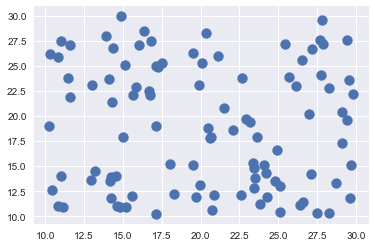

In [5]:
plt.scatter(A[:, 1], A[:, 2], s=np.size(A,axis=0))

[x1, x2] = squaredDistSolforSingle(H,A,C,41)

In [6]:
index_array=np.arange(100)
def ALA(H=[], A=[], C=[], index_array=index_array): 
    
    x_star = np.zeros(shape=(50,2))
    indices = np.random.choice(index_array, 2, replace=False) 
    for i in range(50):
        indices = np.random.choice(index_array, 2, replace=False)   
        cost_facility = np.delete(C[i], 0)[indices] #i is the facility number
        x1_star_new = (np.sum(np.multiply(np.multiply(H[indices][:,1],cost_facility),A[indices][:,1]))/np.dot(H[indices][:,1], cost_facility))
        x2_star_new = (np.sum(np.multiply(np.multiply(H[indices][:,1],cost_facility),A[indices][:,2]))/np.dot(H[indices][:,1], cost_facility))
        x_star[i] = [x1_star_new,x2_star_new]
        index_array=np.setdiff1d(index_array,indices)
        if(index_array.size==0):
            break
       #COST FUNCTION KOYULUP UPDATE YAPILACAK
        #dist yakınlığına göre reassignment yapılacak     
    return x_star

x_star=ALA(H,A,C)